# Why software projects take longer than you think

– Jon Tingvold, 2019

#### Abstract
It is a well-known fact that programming is prune to be underestimated. But why? Are developers just bad at estimating, or is there something more fundamental to it? Based on data from a software company in the UK, it seems like developers are actually good at estimating the median task time, but the uncertainty (standard deviation) is huge and as a consequence, the average task time blows up because of the nature of log-normal distributions and longer tailed log distributions. The takeaway message is that developers should focus on reducing uncertainty and build familiar products.

#### Dataset
The dataset used is the [SiP dataset](https://github.com/Derek-Jones/SiP_dataset), a dataset of effort estimates on **10,000 tasks** by **22 developers** on **20 projects** between 2004–2014 at Software in Partnership (SiP), an insurance system maker.

#### Results
If we define the blowup_factor as the ratio actual_task_time/expected_task_time, we can see that  **median(blowup_factor)=1.00**, while the **average(blowup_factor)=1.88**. The uncertainty is large, with a **standard deviation of 6.54**.

The blowup_factor fits quite well a **log-normal distribution**. If we think about log(task_hours) as the complexity and log(blowup_factor) as complexity_error, the complexity_error fits quite well a normal distribution. It is a bit long-tailed. The distribution, which has a standard deviation of 0.99, has an **excess kurtosis of 3.14**. It, therefore, might fit better a t-distribution.

#### Discussion
It is hard to know if this dataset is representative for the average developer, but it seems likely that developers estimates are much closer to the median time than the average, and that the estimates are close to log-normally distributed. 

How long-tailed the log blowup factor is, and how the blowup factor's standard deviation is distributed is harder to know, and probably depends a lot on the project and developer. Theoretically, the mean for log-t-distribution does not exist. It blows up if the degree of freedom is low because of extreme values. That makes the mean inherently difficult to estimate.

In practice it might be easier to think of the blowup factor as log-normally distributed and be aware of extreme events and that tasks might be unfeasible to finish. But even under a log-normal distribution and when the median = 1 (complexity error = 0), the average blowup factor will probably be around 1.25–3.0, depending on the st.d. of the complexity error (uncertainty).

#### Conclusion and  takeaway lesson
In median terms, a software task looks neither under- or overestimated. But because the blowup factor is log-normal (or log-t) distributed, tasks are profoundly underestimated on average. 

If this is true, it is not strange that software projects are prone to be underestimated.

It also shows how important risk management in software projects is. If we can build familiar and standardized products, we can decrease the uncertainty. If developers indeed estimate the median development time and not the average, decreased uncertainty will lower the development time; under long-tailed log-distributions, it will decrease dramatically. Even if the estimated time indicate that a shortcut is faster, the expected development time might be lower if we build familiar products.


# Code

### Imported packages

In [1]:
import scipy.stats as stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import scipy.stats as st
from IPython.display import HTML, Image, Video, Markdown

# Matplotlib style sheet
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-pastel')
plt.style.use('jont')

## Dataset

In [3]:
ds = pd.read_csv("data.csv")

print("Rows:", len(ds))

ds.head()

Rows: 12299


,TaskNumber,Summary,Priority,RaisedByID,AssignedToID,AuthorisedByID,StatusCode,ProjectCode,ProjectBreakdownCode,Category,SubCategory,HoursEstimate,HoursActual,DeveloperID,DeveloperHoursActual,TaskPerformance,DeveloperPerformance
0,1735,Flag RI on SCM Message Summary screen using me...,1,58,58,6.0,FINISHED,PC2,PBC42,Development,Enhancement,14.0,1.75,58,1.75,12.25,12.25
1,1742,Allow RI Policies to be marked as Exhausted,1,58,42,6.0,FINISHED,PC2,PBC21,Development,Enhancement,7.0,7.00,42,7.00,0.00,0.00
2,1971,Fix Invalid UWREF Line DX402L99A1N,2,7,58,6.0,FINISHED,PC2,PBC75,Operational,In House Support,0.7,0.70,58,0.70,0.00,0.00
3,2134,New rows in the diary event for the SCM are re...,5,50,42,6.0,FINISHED,PC2,PBC42,Development,Bug,0.7,0.70,42,0.70,0.00,0.00
4,2251,Application Screen Size - Need to set Min Size...,10,46,13,6.0,FINISHED,PC2,PBC21,Development,Bug,3.5,3.50,13,3.50,0.00,0.00


### Estimated vs. actual development time

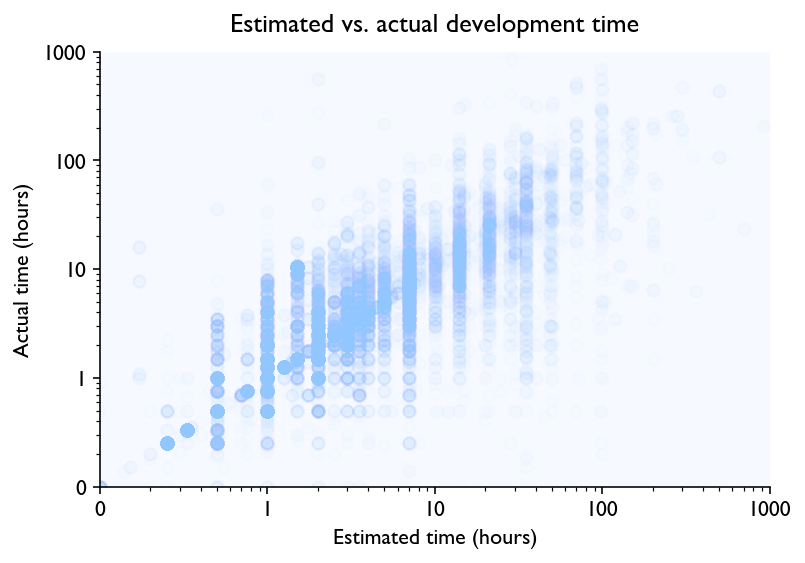

In [4]:
fig, ax = plt.subplots()
ax.scatter(ds.HoursEstimate, ds.HoursActual, alpha=0.02)

ax.set_title('Estimated vs. actual development time')
ax.set_xlabel('Estimated time (hours)')
ax.set_ylabel('Actual time (hours)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.1, 1000)
ax.set_ylim(0.1, 1000)
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())

### —
Log-log scale

High accuracy, but the uncertainty is huge!

## Complexity

Because hours looks like they explode, it can be nice to have a more linear mapping with a logarithmic scale, something like a dB scale to sound pressure. We can define this logarithmic scale of the time a task takes as its ***complexity***.

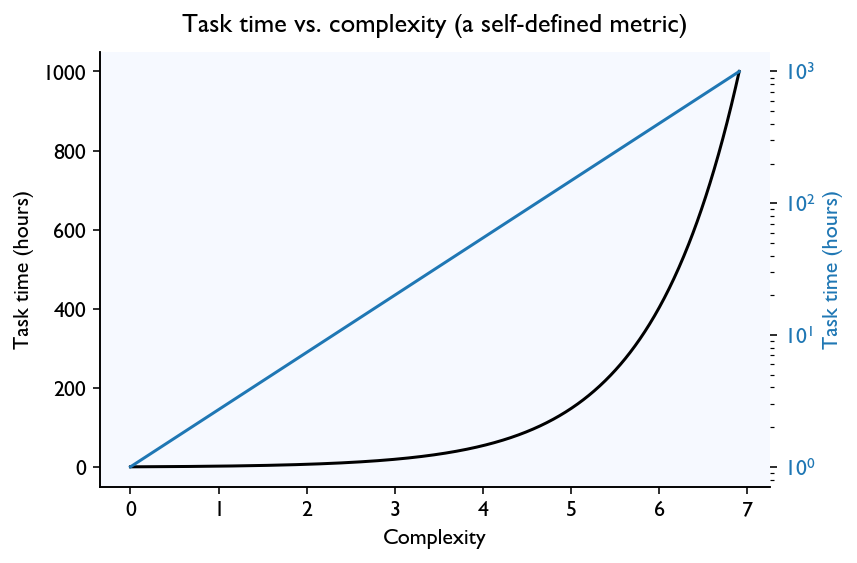

In [5]:
complexity = np.linspace(0, np.log(1000), 1000)
task_time_hours = np.exp(complexity)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.plot(complexity, task_time_hours, "black")
ax1.set_title('Task time vs. complexity (a self-defined metric)')
ax1.set_xlabel('Complexity')
ax1.set_ylabel('Task time (hours)')

ax2.plot(complexity, task_time_hours, "tab:blue")
ax2.set_yscale("log")
ax2.set_ylabel("Task time (hours)", color="tab:blue")
ax2.tick_params(axis='y', labelcolor="tab:blue")

fig;

## Complexity, blowup factor and complexity error

In [6]:
# Define complexity
complexity_estimated = np.log(ds.HoursEstimate)
complexity_actual = np.log(ds.HoursActual)

# Define blowup factor
blowup_factor = ds.HoursActual / ds.HoursEstimate

# Define complexity error (log of blowup factor)
complexity_error = np.log(blowup_factor)
# Same as: complexity_error = complexity_actual - complexity_estimated

### Distribution of blowup factor

Median: 1.04
Mean: 1.89
St.dev: 7.07


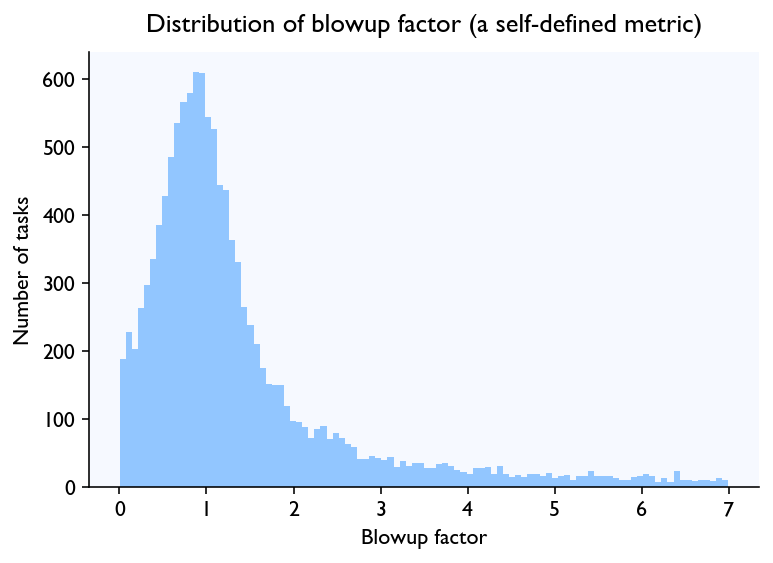

In [23]:
selector = (blowup_factor < 7) & (blowup_factor > 0)
fig = blowup_factor[selector].hist(bins=100, grid=False)
fig.set_title('Distribution of blowup factor (a self-defined metric)')
fig.set_xlabel('Blowup factor')
fig.set_ylabel('Number of tasks')

print("Median: %.2f" % np.median(blowup_factor))
print("Mean: %.2f" % np.mean(blowup_factor))
print("St.dev: %.2f" % np.std(blowup_factor))

fig;

### Distribution of complexity error (log of blowup factor)

Median: 0.04
Mean: 0.04
St.dev: 0.99
Skew: -0.30
Excess kurtosis: 3.30


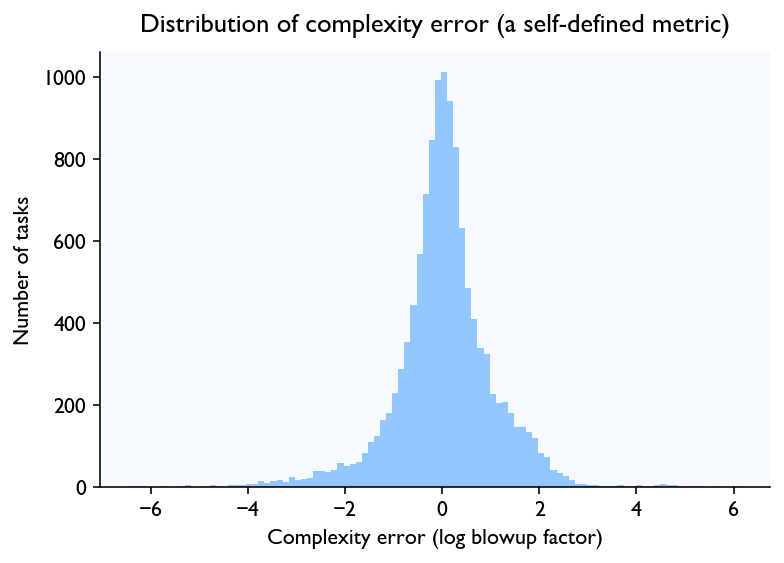

In [24]:
fig = complexity_error.hist(bins=100, grid=False)
fig.set_title('Distribution of complexity error (a self-defined metric)')
fig.set_xlabel('Complexity error (log blowup factor)')
fig.set_ylabel('Number of tasks')

print("Median: %.2f" % np.median(complexity_error))
print("Mean: %.2f" % np.mean(complexity_error))
print("St.dev: %.2f" % np.std(complexity_error))
print("Skew: %.2f" % stats.skew(complexity_error))
print("Excess kurtosis: %.2f" % stats.kurtosis(complexity_error))

fig;

### —
The blowup factor has a lot of values around 1.0, 2.0, 3.0, 4.0, and so on. Maybe because developers estimate task in fixed intervals and the actual time is recorded in whole hours, and maybe set to the same as estimated time if they are quite close.

This makes the distributed hard to work for.

## Correct for discrete values

To correct for this we add some normal drawn noise values with st.d.=0.3 to complexity error.

In [9]:
# Add 0.3 randomness on average (std) to complexity_error
complexity_error = np.log(ds.HoursActual / ds.HoursEstimate)
complexity_error = complexity_error + np.random.normal(loc=0, scale=0.3, size=len(ds.HoursEstimate))
blowup_factor = np.exp(complexity_error)

### Distribution of blowup factor after correction

Median: 1.04
Mean: 1.89
St.dev: 7.07


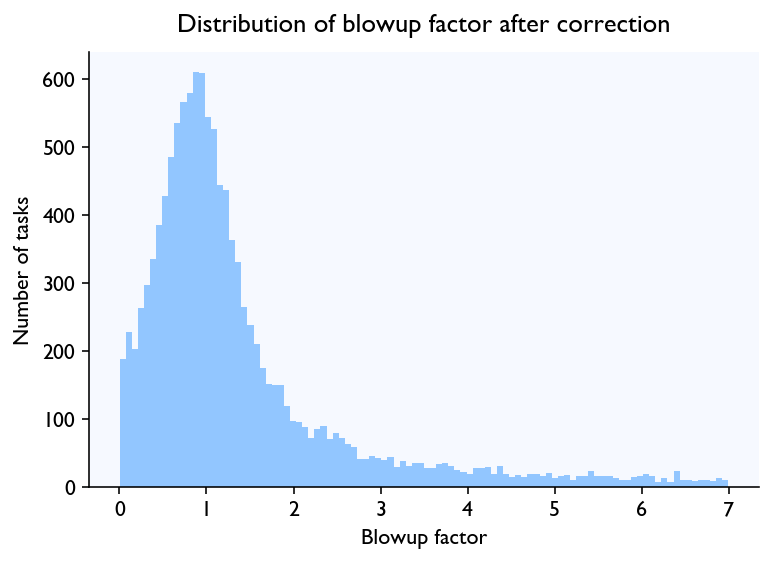

In [25]:
fig = blowup_factor[blowup_factor < 7].hist(bins=100, grid=False)
fig.set_title('Distribution of blowup factor after correction')
fig.set_xlabel('Blowup factor')
fig.set_ylabel('Number of tasks')

print("Median: %.2f" % np.median(blowup_factor))
print("Mean: %.2f" % np.mean(blowup_factor))
print("St.dev: %.2f" % np.std(blowup_factor))

fig;

### Distribution of complexity error after correction

Median: 0.04
Mean: 0.04
St.dev: 0.99
Skew: -0.30
Excess kurtosis: 3.30


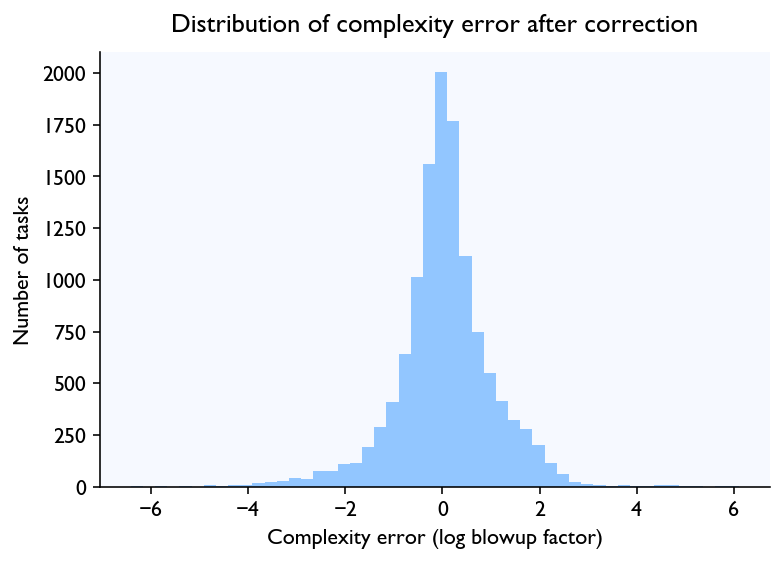

In [26]:
fig = complexity_error.hist(bins=50, grid=False)
fig.set_title('Distribution of complexity error after correction')
fig.set_xlabel('Complexity error (log blowup factor)')
fig.set_ylabel('Number of tasks')

print("Median: %.2f" % np.median(complexity_error))
print("Mean: %.2f" % np.mean(complexity_error))
print("St.dev: %.2f" % np.std(complexity_error))
print("Skew: %.2f" % stats.skew(complexity_error))
print("Excess kurtosis: %.2f" % stats.kurtosis(complexity_error))

fig;

### —
After the correction, the two distributions look more natural. The blowup log factor is a bit skewed and quite long-tailed with an excess kurtosis of ca. 3. The st.d is 0.99.

## Comparison with true normal distribution

Let's compare with a normal distribution with the same st.d of 0.99, and the consequential log-normal distribution of the blowup factor, and see how close they are.

In [12]:
# Draw normal distributed numbers
mean = 0
std = 0.99

s = np.random.normal(mean, std, size=10000)

Median: -0.01
Mean: -0.00
St.dev: 0.98
Skew: -0.01
Excess kurtosis: 2.49


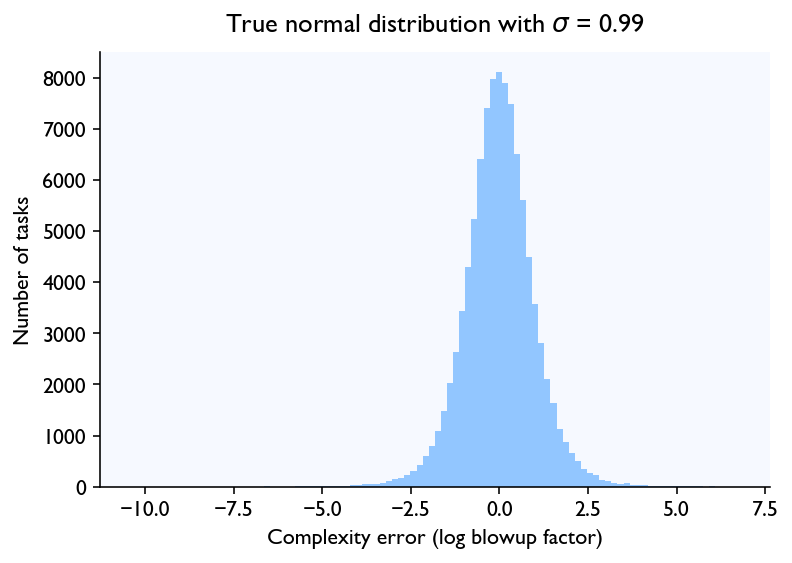

In [27]:
df = pd.Series(s)
fig = df[df<7].hist(bins=100, grid=False)
fig.set_title('True normal distribution with $\sigma$ = 0.99')
fig.set_xlabel('Complexity error (log blowup factor)')
fig.set_ylabel('Number of tasks')

print("Median: %.2f" % np.median(df))
print("Mean: %.2f" % np.mean(df))
print("St.dev: %.2f" % np.std(df))
print("Skew: %.2f" % stats.skew(df))
print("Excess kurtosis: %.2f" % stats.kurtosis(df))

fig;

Median: 0.99
Mean: 2.36
St.dev: 161.37


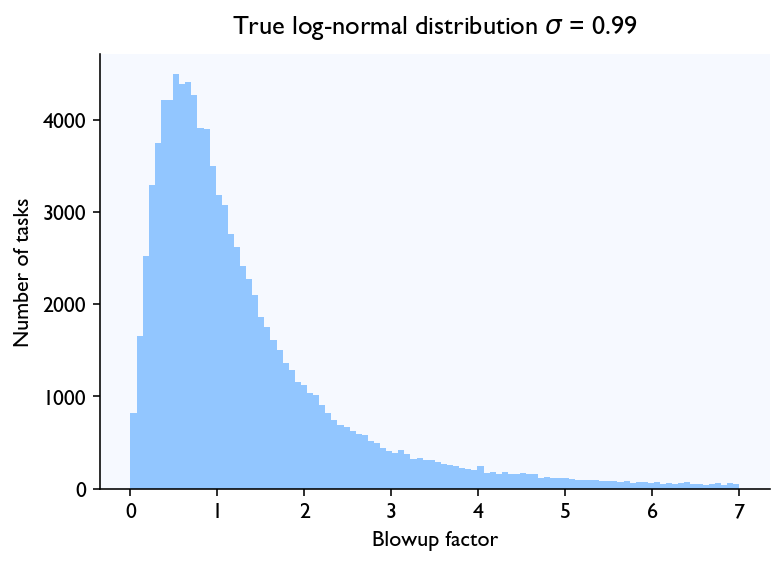

In [28]:
df = pd.Series(np.exp(s))
fig = df[df<7].hist(bins=100, grid=False)
fig.set_title('True log-normal distribution $\sigma$ = 0.99')
fig.set_xlabel('Blowup factor')
fig.set_ylabel('Number of tasks')

print("Median: %.2f" % np.median(df))
print("Mean: %.2f" % np.mean(df))
print("St.dev: %.2f" % np.std(df))

fig;

### True average blowup factor if log-normally distributed

In [15]:
sigma = 0.99
average_log_normal = np.exp(0.5*sigma**2)
Markdown("True average blowup factor if log-normal: **%.2f**" % average_log_normal)

True average blowup factor if log-normal: **1.63**

### —
We can see the difference in the distributions. The normal distribution is considerbly
more short-tailed.

The consequence is that the mean of blowup_factor=1.65, a bit lower than the real distributions 1.88,

## Comparison with true student-t distribution (long-tailed normal)

Let's try making a longer tailed distribution, with the same st.d. and kurtosis. 
A good distribution for this is the student-t distribution. After some try-and-error, it looks like
a degree of freedom of 6 and st.d=0.80 emulates quite good the distribution we are looking for.

In [16]:
# Draw some random numbers from a t-distribution. 
mean = 0
std = 0.80
s = mean + std*np.random.standard_t(df=6, size=100000)

Median: -0.01
Mean: -0.00
St.dev: 0.98
Skew: -0.01
Excess kurtosis: 2.49


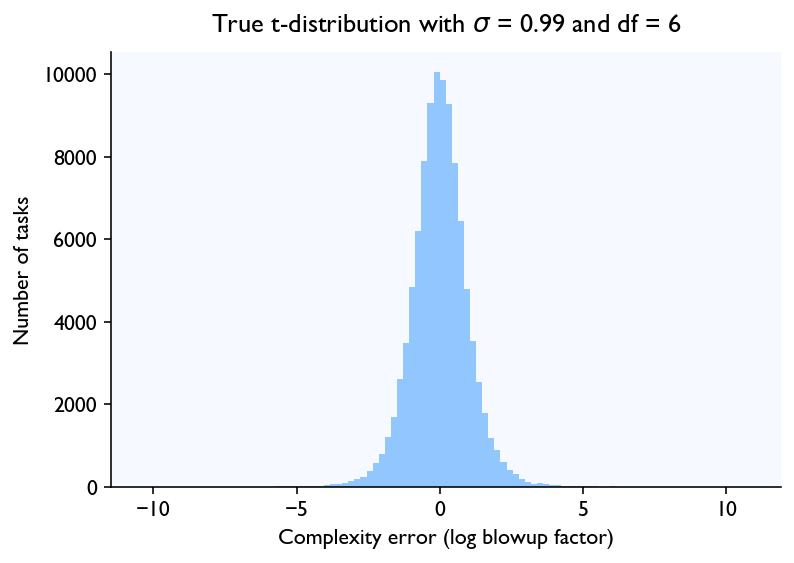

In [29]:
df = pd.Series(s)
fig = df.hist(bins=100, grid=False)
fig.set_title('True t-distribution with $\sigma$ = 0.99 and df = 6')
fig.set_xlabel('Complexity error (log blowup factor)')
fig.set_ylabel('Number of tasks')

print("Median: %.2f" % np.median(df))
print("Mean: %.2f" % np.mean(df))
print("St.dev: %.2f" % np.std(df))
print("Skew: %.2f" % stats.skew(df))
print("Excess kurtosis: %.2f" % stats.kurtosis(df))

fig;

Median: 0.99
Mean: 2.36
St.dev: 161.37


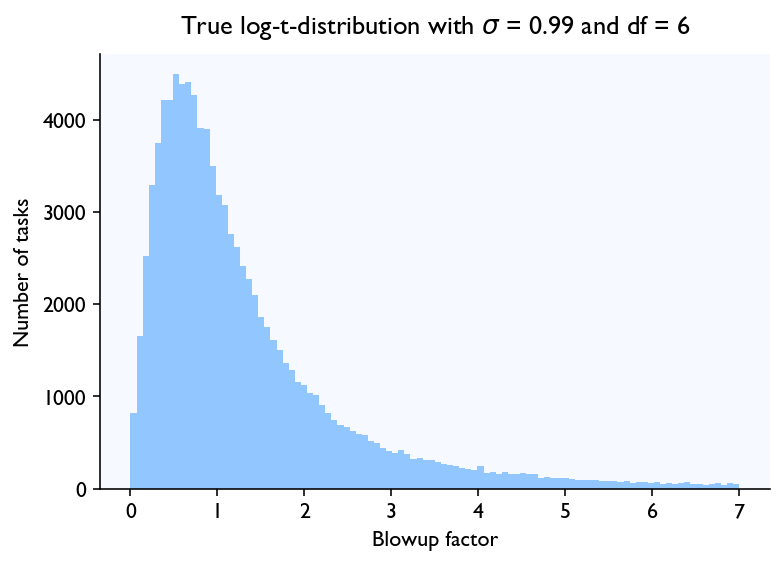

In [30]:
df = pd.Series(np.exp(s))

fig = df[df<7].hist(bins=100, grid=False)
fig.set_title('True log-t-distribution with $\sigma$ = 0.99 and df = 6')
fig.set_xlabel('Blowup factor')
fig.set_ylabel('Number of tasks')

print("Median: %.2f" % np.median(df))
print("Mean: %.2f" % np.mean(df))
print("St.dev: %.2f" % np.std(df))

fig;

### True average blowup factor if log-t distributed
Infinite for all log-t distributions


### —
Now we have a better approximation of the true distribution of the blowup_factor. The mean also a bit higher, around 1.80–2.20. However, because of extreme values, the mean is quite unstable and often blows up to 4.0 or even more if you increase the sample size. 

**Important!** In fact, the mean of the log t-distribution does not exist!

So if the blowup factor is actually long-tailed distributed in most software projects, it is not strange that the average task time is difficult to estimate.

On the other hand, the mean is unstable because of extreme events. In practice, it is easier to model the distribution as a log-normal distribution and be aware of extreme events.

### How the average blowup grow with uncertainty
***—Even if average complexity error = 0***

Let's see how the average blowup factor grow with increased standard deviations of complexity error if the blowup factor had been log-normally distributed. 


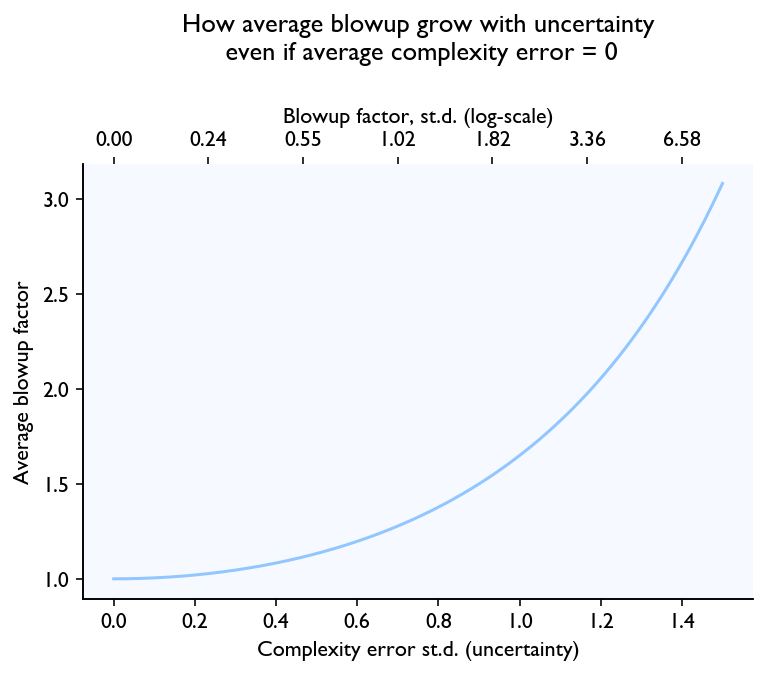

In [19]:
mu = 0
sigmas = np.linspace(0.0, 1.5, num=1000)
mean_lognormal = np.exp(0.5*sigmas**2)
get_std_lognormal = lambda mu, sigmas: np.sqrt((np.exp(sigmas**2)-1)*np.exp(2*mu + sigmas**2))

# Plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(sigmas, mean_lognormal)
ax1.set_title("How average blowup grow with uncertainty\n even if average complexity error = 0\n")
ax1.set_xlabel("Complexity error st.d. (uncertainty)")
ax1.set_ylabel("Average blowup factor")

def set_tick_labels(sigmas):
    labels = ["%.2f" % get_std_lognormal(mu, sigma) for sigma in sigmas]
    return labels

lines = ax2.plot(sigmas, np.ones(len(mean_lognormal))) # Create a dummy plot
ticks = np.linspace(0, 1.4, 7)
ax2.set_xticks(ticks)
ax2.set_xticklabels(set_tick_labels(ticks))
ax2.set_xlabel("Blowup factor, st.d. (log-scale)")
lines.pop(0).remove()

print()
fig;

### —
We see that even if developers are quite good at estimating the complexity and the average complexity error = 0 (and the median blowup factor = 0), the average blowup factor increases rapidly with increased uncertainty, which we can define as the standard deviation of complexity error. 

## Conclusion

So to sum up: The median blowup factor is ca. 0. The average blowup factor is not zero, because under log-normal distributions (or log-t) the mean higher than the median, and grow with higher uncertainty/standard deviation. The average blowup is ca. 1.5–3.0, but depend a lot on the uncertainty. Under more long-tailed distributions than log-normal, the mean gets unstable and blows up because of extreme values.